In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

from pathlib import Path

# this adds the CANOSP root to the path, so we can import from there
import sys
sys.path.append('../')

# root of the repository
canosp_root_path = Path("./..")
data_path = canosp_root_path/"data"

In [2]:
from fastai.text import *

In [3]:
train = pd.read_csv(data_path/"final_train.csv")
train.head()

,ticket_id,session,java,download,file,account,refresh,homepage,button,paste,...,reinstall,mac,youtube,image,toolbar,load,library,window,restore,title_content
0,955006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,>
1,1066283,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,delete deleted
2,1233313,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,open new window letter n w right click menu mo...
3,1233322,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,web camera picture localhost 65 office picture...
4,1233348,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,firefox hang high cpu use try open local file ...


In [4]:
train['title_content'] = train['title_content'].str.replace('([“”¨«»®´·º½¾¿¡§£₤‘’])', '')

In [5]:
test = pd.read_csv(data_path/"final_test.csv")

test_id = test['ticket_id']
test['title_content'] = test['title_content'].str.replace('([“”¨«»®´·º½¾¿¡§£₤‘’])', '')

In [6]:
data = (TextList.from_df(train, cols="title_content")
                .split_by_rand_pct(0.2)
                .label_for_lm()  
                .databunch(bs=48))
data.show_batch()

idx,text
0,valid xxunk xxunk xxunk xxunk xxbos firefox hang high cpu use try open local file mean try mean open local html file folder tab xxunk forever spin high cpu use unresponsive form xxunk kill task manager mean try include ff file open select html file ff use file : / / c : / window explorer context menu open > firefox window explorer drag html file firefox address bar window
1,setting need people need xxbos add google play store app add on google account access google play store firefox browser instruct setting click account add google play find set firefox browser like xxunk exit xxbos firefox will open xxunk page take circle help firefox will open try refresh say run background delete will open reason xxunk troubleshoot page take xxunk circle need help know play xxunk user bring computer technology
2,xxunk hotmail transition beta way return xxunk attempt view email account mozilla xxunk sure hope able xxunk prefer use firefox xxunk xxbos flash player banner flicker scroll issue solve online radio be xxunk flash player webpage scroll flicker normal stop scroll flash banner forum hardware acceleration disable xxunk flicker restart ff safe mode issue try figure possible xxunk hardware acceleration flash player configuration xxunk option available option finally find solution
3,search thing like clipboard win 10 bing bing xxunk read xxunk problem help gratefully xxunk xxbos firefox upload bookmark datum recent relate article state description field remove user interface bookmark manager library xxunk information store bookmark description xxunk cloud collect xxunk xxunk imply description come xxunk xxunk forbid xxunk information long available html export xxbos firefox set clear cookie firefox set remember cooky select site erase cooky internet history close
4,os x specific test window ubuntu able copy multiple link problem file bug report zero activity response expect overnight 7 month nice xxunk problem real day roll xxunk xxbos xxunk info track protection understand basic xxunk track protection unable find answer specific question find documentation question answer section provide answer 1 need clear exist cooky remove xxunk site track turn track protection turn immediate filter exist cooky 2 turn track


In [7]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

In [8]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


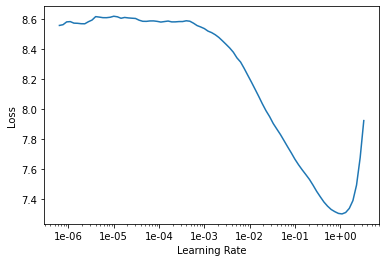

In [9]:
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,7.710621,6.026213,0.140179,00:01
1,6.640988,5.468813,0.161548,00:01
2,6.060260,5.320247,0.171012,00:01
3,5.664231,5.268380,0.173512,00:01
4,5.390822,5.261236,0.173393,00:01


In [11]:
learn.save_encoder('fine_tuned_enc')

In [12]:
with open(canosp_root_path/"candidate_tags/roland_edit_all_methods_intersection.txt") as f:
    candidate_tags = [line.strip() for line in f.readlines()]
    
# candidate_tags.remove("firefox")
    
label_cols = candidate_tags
label_cols

['session',
 'java',
 'download',
 'file',
 'account',
 'refresh',
 'homepage',
 'button',
 'paste',
 'google',
 'save',
 'permission',
 'reader',
 'email',
 'norton',
 'pdf',
 'freeze',
 'search',
 'microsoft',
 'flash',
 'log',
 'website',
 'aol',
 'audio',
 'facebook',
 'attachment',
 'sync',
 'navigation',
 'network',
 'cache',
 'uninstall',
 'connection',
 'shortcut',
 'password',
 'bookmark',
 'history',
 'yahoo',
 'background',
 'block',
 'beta',
 'downgrade',
 'upload',
 'keyboard',
 'dialog',
 'printer',
 'setup',
 'safari',
 'enable',
 'dropdown',
 'popup',
 'profile',
 'slow',
 'display',
 'content',
 'drag',
 'theme',
 'ubuntu',
 'sign',
 'send',
 'install',
 'upgrade',
 'error',
 'player',
 'adobe',
 'virus',
 'certificate',
 'restart',
 'explorer',
 'script',
 'import',
 'sound',
 'scroll',
 'username',
 'speed',
 'font',
 'export',
 'reset',
 'icon',
 'bank',
 'javascript',
 'form',
 'exception',
 'redirect',
 'gmail',
 'memory',
 'format',
 'launch',
 'disable',
 'secur

In [13]:
test_datalist = TextList.from_df(test, cols='title_content', vocab=data.vocab)

data_clas = (TextList.from_df(train, cols='title_content', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols=label_cols , classes=label_cols)
             .add_test(test_datalist)
             .databunch(bs=32))

data_clas.show_batch()

text,target
xxbos constant crash hello ! i xxunk xxunk use the browser anymore . it xxunk xxunk i keep it open in background xxunk xxunk 1 tab or xxunk xxunk xxunk it . this xxunk xxunk xxunk xxunk august 2017 xxunk year . i have xxunk the xxunk to this xxunk . thank you . - xxunk the xxunk one xxunk xxunk xxunk i have xxunk to open the browser xxunk,background;open;crash
xxbos work mozilla firefox xxunk xxunk xxunk xxunk xxunk xxunk log kill work xxunk authorize xxunk xxunk mainly xxunk xxunk etc xxunk xxunk hell xxunk force target xxunk xxunk xxunk xxunk authorize xxunk rule xxunk xxunk intentionally xxunk xxunk till present time 01 / xxunk / xxunk xxunk force alike xxunk mainly xxunk xxunk xxunk alike xxunk rule xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,error
xxbos firefox crash firefox crash time especially xxunk think video card go buy new video xxunk xxunk uninstalled firefox reinstall firefox disable addons disable hardware xxunk problem browser xxunk list submit crash report report would date xxunk xxunk xxunk 10 / 31 / 2019 8:42 xxunk xxunk xxunk xxunk xxunk 10 / 31 / 2019 8:42 xxunk xxunk xxunk xxunk 10 / 31 / 2019 8:42 pmbp xxunk xxunk xxunk,facebook;error;memory;crash;load
xxbos firefox crash start error show firefox developer edition update unsure restart update click firefox icon firefox process task manager time quit show window error message try enter safe mode press shift start firefox result process quit show dialog enter safe mode try uninstall install firefox result remove profile xxunk appdata% \ mozilla \ firefox \ profiles \ record window log start attempt < event xxunk = window error report,error;crash
xxbos xxunk update v65 complex session invoke automatic refresh create old firefox datum folder desktop change firefox setting today xxunk update v65 complex session invoke automatic refresh create old firefox datum folder desktop change firefox setting window 10 pro 64-bit update present operation normal stable subject event minimize browser work email client thunderbird firefox default click link thunderbird normally xxunk come pass click click double click link xxunk xxunk xxunk,session;refresh;error;update


In [14]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_classifier.load_encoder('fine_tuned_enc')
learn_classifier.freeze()

In [15]:
learn_classifier.lr_find()

epoch,train_loss,valid_loss,time
0,0.738120,#na#,00:03
1,0.552306,#na#,00:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


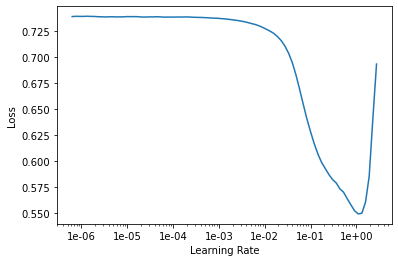

In [16]:
learn_classifier.recorder.plot()

In [17]:
learn_classifier.fit_one_cycle(6, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.577191,0.250084,00:03
1,0.238246,0.092836,00:03
2,0.142125,0.086829,00:04
3,0.105361,0.083484,00:04
4,0.089055,0.082392,00:03
5,0.080948,0.081908,00:03


In [18]:
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.081655,0.086486,00:03


In [19]:
learn_classifier.freeze_to(-3)
learn_classifier.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.078552,0.082323,00:04


In [20]:
learn_classifier.show_results(rows=1000)

text,target,prediction
xxbos crash xxunk report xxunk build:{applicationid:{ec8030f7-c20a-464f-9b0e-13a3a9e97384}applicationname firefoxarchitecture x86 xxunk xxunk xxunk true}partner:{distributionid nulldistributionversion nullpartnerid nulldistributor nulldistributorchannel xxunk xxunk ha xxrep 4 s e3hassse4_1hassse4_2hasavxhasavx2hasaes]}os:{name xxunk en xxunk mtfddak256mbf-1an15abharevision xxunk mtfddak256mbf-1an15abharevision xxunk mtfddak256mbf-1an15abharevision xxunk xxunk xxunk xxunk xxunk xxunk hd graphic xxunk nulldriver xxunk xxunk xxunk xxunk xxunk xxunk 8 xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk truee10senabled xxunk falselocale en xxunk releaseenabled trueautodownload true}userprefs:{browser.search.widget.innavbar,account;log;startup;crash,
xxbos bing google will load say connection secure give follow xxunk use invalid security certificate certificate trust issuer certificate unknown server send appropriate xxunk certificate additional root certificate need import error code xxunk peer certificate issuer recognize http strict transport security true http public key pin false certificate chain xxrep 5 - begin certificate xxrep 5 - xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk + xxunk xxunk xxunk xxunk,google;connection;certificate;security;bing,
xxbos suspicious firefox survey mozilla would 3 inane questions win free iphone ask credit card pay $ 1 xxunk fee xxunk investigate xxunk firefox survey highly suspicious ask 3 inane question like use firefox use xxunk xxunk free iphone x display suppose xxunk email xxunk joy xxunk wonderful gift come quickly mail ask would address e mail credit card info request authorize $ xxunk payment cover ship xxunk xxunk xxunk,content,
xxbos firefox 71 work window 7 laptop hello similar problem mention discussion solution give help afraid use firefox automatic update switch 3 system 2 window 7 1 window 10 firefox update 71 3 system window 10 installation go xxunk 2 window 7 system problem resolve unfortunately update window 7 laptop go firefox unusable system firefox 71 update firefox keep crash time try run show window error box state firefox stop,error;startup;update;crash,
xxbos disable update xxunk go shit board option restore xxunk care policy file xxunk care way think xxunk go response kindly suck shoot xxunk xxunk miss absolutely reason checkbox go absolutely reason edit xxunk json file xxunk party text editor prevent checkbox right configure xxunk xxunk bloat ram xxunk suck software program xxunk xxunk fire xxunk xxunk suggest implement bug fix want update window xxunk quit window edit xxunk restart,upgrade;disable;default;update;restore,
xxbos firefox crash hello get error message xxunk tab xxunk help choose restore tab reload page update firefox safe mode error keep happen crash report i d report would date xxunk xxunk xxunk xxunk 22 / 10 / 2019 xxunk xxunk xxunk xxunk 22 / 10 / 2019 xxunk xxunk xxunk xxunk xxunk 22 / 10 / 2019 xxunk bp xxunk xxunk xxunk xxunk 22 / 10 / 2019 xxunk,beta;error;tab;crash;restore,
xxbos delete history need real email address explain xxunk xxunk xxunk xxunk old learn disable xxunk visit have ditch pc screw xxunk get big screen imac away source xxunk permission time xxunk imac geek install call xxunk speed dial allow xxunk frequently website xxunk time leave site similar xxunk speed dial pop show site invoke non geek mac firefox friend say problem xxunk site go history follow prompt select xxunk,email;history,
xxbos firefox xxunk esr work ok xxunk fail render xxunk xxunk wikipedia work box .css issue question ask try solution adblock disable cooky cache clear theme set default config option tweak default specific example wikipedia site xxunk xxunk xxunk image fail render appear briefly disappear flash plugin disable default .css file alter check note ff menu tool page info medium show xxunk image fine click blank screen image right click,cache;error;load,
xxbos ok xxunk not sign xxunk force second d

In [21]:
ticket_dict = {}

with open(data_path/"mturk_tickets.json", "r") as f:
    tickets = json.loads(f.read())["tickets"]
    for ticket in tickets:
        ticket_dict[str(ticket["ticket_id"])] = ticket

In [48]:
ticket_dict["808689"].keys()

dict_keys(['ticket_id', 'title', 'content', 'timestamp', 'tags'])

In [57]:
import csv

pred_threshold = 0.2

preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = preds.numpy()

In [58]:
# create CSV writer
csv_file = open(data_path/"final_class_output.csv", "w", newline="")
csv_writer = csv.writer(csv_file, delimiter=",")

# write the CSV header
# ticket_id end_time judgement_id start_time tagger_id tags
csv_columns = ["ticket_id", "title", "content", "pred_tags"]
csv_writer.writerow(csv_columns)

for i in range(len(test_datalist.items)):
    ticket_id = str(test_id[i])
    tags = []
    for j in range(len(candidate_tags)):
        if labels[i][j] > pred_threshold:
            tags.append(candidate_tags[j])
            
#     print("ID:", ticket_id)
#     print("Title:", ticket_dict[ticket_id]["title"])
#     print("Content:", ticket_dict[ticket_id]["content"])
#     print("Tags:", ", ".join(tags))
#     print()
    
    csv_row = [ticket_id, ticket_dict[ticket_id]["title"], ticket_dict[ticket_id]["content"], ",".join(tags)]  
    csv_writer.writerow(csv_row)
            
csv_file.close()

In [56]:
class_results = pd.read_csv(data_path/"final_class_output.csv")
class_results

,ticket_id,title,content,pred_tags
0,1277462,DOM is not updated properly for Angular web ap...,"<p><a href=""https://www.educatingkids.com.au/""...","error,update"
1,1277474,Export console hxr responses,<p>I'm trying to automate a part of my daily w...,"error,update"
2,1277490,can i transfer passwords from 1 pc to another,<p>I have very basic computer skills and due t...,"login,update"
3,1277553,firefox keeps going back to previous page rand...,"<p>i have the same OS and all else is same, bu...","error,tab,update"
4,1277566,Parts of Ancestry.co.uk no longer working with...,<p>I have consistently used Firefox as my brow...,"error,update"
...,...,...,...,...
95,1280240,I downloaded a english dictionary for spellche...,<p>I downloaded a english dictionary for spell...,"download,file,error,print,video"
96,1280265,The quick save bookmark star (to 3 dots) went ...,<p>Earlier today I noticed on my Firefox 72.0....,"tab,update,restore"
97,1280314,Can someone help me with the PR_END_OF_FILE_ERROR,<p>I am facing this PR_END_OF_FILE_ERROR probl...,"website,error,update"
98,1280327,"Firefox 73.0.1 was working fine, suddenly all ...",<p>Have been using Firefox heavily (as usual) ...,"error,update,crash"


In [29]:
tag_set = set(candidate_tags)
all_set = set()

for ticket in ticket_dict.values():
    for tagger, tags in ticket["tags"].items():
        if tagger != "0":
            for tag in tags:
                all_set.add(tag)

print(all_set)
print(tag_set)
print(tag_set - all_set)

{'', 'extra', 'signup', 'vpnerror', 'Wikipedia', 'correction', 'autoscrolling', 'ticker', 'uninstall/install', 'future-version', 'favorite', 'dries', 'qr', 'avast', 'help', 'tex', 'sunsetting', 'webrender', 'nonfunctional', 'frames', 'favicon', ' recover', 'iframes', 'ff67', 'website-contains-content', 'choppy', 'b&w', 'viewing', 'button', 'resetting', 'no-error', 'recurring', 'firefox65', 'cash', 'gsm', 'uploads', 'debued', 'unsecureconnection', 'barff', 'webpage-refreshing', 'system.', 'primary', 'outline', 'regional', 'etc', 'pain', 'bold', 'bugzilla', 'way', 'instruct', 'setup', 'multi-dispaly', 'dissapear', 'clenup', ' pinned', 'whats', 'cord', 'feature', 'technical', 'zibbet.com', 'ios12', 'searchbar', 'tabbox', 'Windows-10', 'world', 'marker', 'new-tab', 'rss', 'tracking', 'legacy', 'loop', 'music', 'profil', 'noob', 'respond', 'esr', 'playback', 'launching', 'glitch', 'may', 'browsing.', 'vanish', 'safeless', 'verify', ' add-on', 'hd', 'stopsloadingpages', 'wordpress', 'externa